### import

In [1]:
BASEDIR="../"

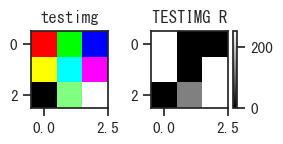

array([[[255,   0,   0],
        [  0, 255,   0],
        [  0,   0, 255]],

       [[255, 255,   0],
        [  0, 255, 255],
        [255,   0, 255]],

       [[  0,   0,   0],
        [128, 255, 128],
        [255, 255, 255]]], dtype=uint8)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", font='MS Gothic', palette='tab10')
import numpy as np
import itertools
import pprint
import colorsys
import cv2
import os
from tqdm import tqdm;from IPython.display import clear_output
from scipy.interpolate import RegularGridInterpolator

def FindImageFiles(directory):
    image_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            # 拡張子がjpgまたはpngの場合にのみ追加
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(filepath)
    return image_files

def FilenameWOExt(path):
    return os.path.splitext(os.path.basename(path))[0]

def Padding(img, targetX, targetY):
    # img.shapeがtargetになる様に右/下 方向に0を追加
    x, y, _ = img.shape
    # iとjがxとy以上であるかチェック
    if targetX < x or targetY < y:
        # そうでなければ元のimgを返す
        return img
    else:
        # パディングする量を計算
        pad_width = ((0,targetX-x),(0,targetY-y),(0,0))
        img2 = np.pad(img,
                      pad_width=pad_width,
                      mode="constant", # パディング方式は定数（constant）で値は0にする
                      constant_values=0)
        return img2

def Scale(image, scale, interpolation=cv2.INTER_NEAREST):
    if scale == 1:
        return image
    else:
        return cv2.resize(image, None, None, scale, scale, interpolation=interpolation)
    
class GridPlot:
    def __init__(self, gridsize: tuple, figsize: tuple = (6, 4)):
        self.fig = plt.figure(figsize=figsize)
        self.x, self.y = gridsize

    def AddImg(self, image, i: int, title="", interpolation="none"):
        ax = self.fig.add_subplot(self.x, self.y, i)

        if len(image.shape) != 3:
            raise TypeError("image shape is wrong!")
        elif image.shape[2] == 1:
            if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
                raise TypeError("image dtype is wrong!")
            elif image.dtype == np.dtype("uint8"):
                im = ax.imshow(image, cmap='gray', vmin=0, vmax=255,
                               interpolation=interpolation)
            elif image.dtype == np.dtype("float32"):
                im = ax.imshow(image, cmap='gray', vmin=0, vmax=1,
                               interpolation=interpolation)
            plt.colorbar(im, ax=ax)  # 凡例バーを表示

        elif image.shape[2] == 3:
            if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
                raise TypeError("image dtype is wrong!")
            elif image.dtype == np.dtype("uint8"):
                # print("uint8 RGB")
                ax.imshow(image, vmin=0, vmax=255, interpolation=interpolation)
            elif image.dtype == np.dtype("float32"):
                # print("float32 RGB")
                ax.imshow(image, vmin=0, vmax=1, interpolation=interpolation)

        else:
            raise TypeError("image shape is wrong!")

        ax.set_title(title)

    def Show(self):
        plt.show()

def Show(image, title="", interpolation="none"):
    fig, ax = plt.subplots()

    if len(image.shape) != 3:
        raise TypeError("image shape is wrong!")
    elif image.shape[2] == 1:
        if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
            raise TypeError("image dtype is wrong!")
        elif image.dtype == np.dtype("uint8"):
            im = ax.imshow(image, cmap='gray', vmin=0, vmax=255,
                           interpolation=interpolation)
        elif image.dtype == np.dtype("float32"):
            im = ax.imshow(image, cmap='gray', vmin=0, vmax=1,
                           interpolation=interpolation)
        plt.colorbar(im, ax=ax)  # 凡例バーを表示

    elif image.shape[2] == 3:
        if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
            raise TypeError("image dtype is wrong!")
        elif image.dtype == np.dtype("uint8"):
            # print("uint8 RGB")
            ax.imshow(image, vmin=0, vmax=255, interpolation=interpolation)
        elif image.dtype == np.dtype("float32"):
            # print("float32 RGB")
            ax.imshow(image, vmin=0, vmax=1, interpolation=interpolation)

    else:
        raise TypeError("image shape is wrong!")

    ax.set_title(title)
    plt.show()


def Save(image, filename, scale=1):  # uint8のみ
    if image.dtype != np.dtype("uint8"):
        image = np.clip(image * 255, a_min=0, a_max=255).astype("uint8")

    image_scaled = Scale(image, scale)
    cv2.imwrite(filename, cv2.cvtColor(image_scaled, cv2.COLOR_BGR2RGB))

def Read(filename, scale=1):
    return Scale(
        cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB), scale
    )

def Devide4(img):
    """
    Divide an RGB image into 4 equally sized quadrants and return a list of 4 numpy arrays.

    Args:
    img: a numpy array of shape (2x, 2y, 3)

    Returns:
    a list of 4 numpy arrays of shape (x, y, 3)
    """
    # Calculate the dimensions of each quadrant
    x, y = img.shape[0] // 2, img.shape[1] // 2

    # Divide the image into quadrants
    img1 = img[:x, :y, :]
    img2 = img[:x, y:, :]
    img3 = img[x:, :y, :]
    img4 = img[x:, y:, :]

    return (img1, img2, img3, img4)

def Merge4(img_list):
    """
    Combine 4 RGB images of shape (x, y, 3) into a single image of shape (2x, 2y, 3).

    Args:
    img_list: a list of 4 numpy arrays of shape (x, y, 3)

    Returns:
    a numpy array of shape (2x, 2y, 3)
    """
    # Extract the dimensions of each quadrant
    x, y = img_list[0].shape[0], img_list[0].shape[1]

    # Create an empty array to hold the merged image
    merged_img = np.zeros((2 * x, 2 * y, 3), dtype=np.uint8)

    # Combine the 4 quadrants into a single image
    merged_img[:x, :y, :] = img_list[0]
    merged_img[:x, y:, :] = img_list[1]
    merged_img[x:, :y, :] = img_list[2]
    merged_img[x:, y:, :] = img_list[3]

    return merged_img

TESTIMG = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    [[255, 255, 0], [0, 255, 255], [255, 0, 255]],
                    [[0, 0, 0], [128, 255, 128], [255, 255, 255]]], dtype="uint8")

grid = GridPlot((1, 2), (3, 1))
grid.AddImg(TESTIMG, 1, "testimg")
grid.AddImg(TESTIMG[:, :, 0].reshape(3, 3, 1), 2, "TESTIMG R")
grid.Show()

Save(TESTIMG, f"{BASEDIR}/tmp/TESTIMG.png")
Read(f"{BASEDIR}/tmp/TESTIMG.png")


### 全色画像の生成

In [3]:
# def RGBStep(IMGSIZE,TILESIZE): 
#     return int(np.cbrt((IMGSIZE//TILESIZE)**2)	)# 色数 < 最大敷詰めブロック数、でもx**3になるようにしないといけない

# RGBStep(4096,16)

必要なタイルサイズと実現したい解像度から、必要な画像サイズを計算

In [4]:
TILESIZE = 22
LUT_3D_SIZE = 32
INDIR = f"{BASEDIR}/IN"

tileN = int(np.ceil(np.sqrt(LUT_3D_SIZE**3)))  # 一辺あたりに入れるタイル数(過大)
tileN_unused = int(np.ceil(np.sqrt(LUT_3D_SIZE**3)))**2 - LUT_3D_SIZE**3  # 余剰タイル数:RGB_STEPのみに依存

imgsize = tileN * TILESIZE  # 画像の一辺の長さ(過大)

print(f"Img size: {imgsize} ^2\tpx")
print(f"Tiles: {tileN} ^2\ttiles")
print(f"UnusedTiles: {tileN_unused}\ttiles")

Img size: 4004 ^2	px
Tiles: 182 ^2	tiles
UnusedTiles: 356	tiles


(4004, 4004, 3) LUT_3D_SIZE 32


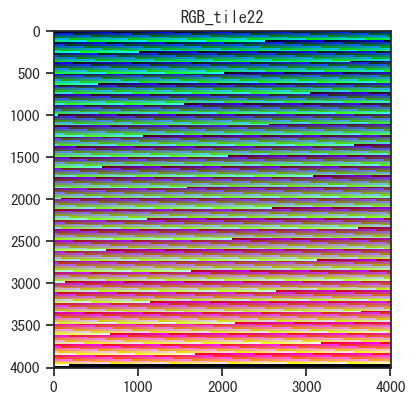

In [5]:
g = GridPlot((1, 4),(20,10))

rgb = np.linspace(0, 255, LUT_3D_SIZE, dtype=np.uint8)
tiles_all = np.stack(np.meshgrid(rgb, rgb, rgb, indexing='ij'), axis=-1) # RGBの組み合わせて
tiles_all = tiles_all.reshape(-1,3) # フラットにする

full_img = np.zeros((imgsize, imgsize, 3), dtype=np.uint8) # IMGSIZE*IMGSIZE の黒画像を作成

for i, tile in enumerate(tiles_all):
    x = i % tileN 
    y = i // tileN #何段目
    full_img[y * TILESIZE:(y + 1) * TILESIZE,
             x * TILESIZE:(x + 1) * TILESIZE] = tile


print(full_img.shape,"LUT_3D_SIZE",LUT_3D_SIZE)
g.AddImg(full_img,2,f"RGB_tile{TILESIZE}")
g.Show()
Save(full_img, f"{INDIR}/RGB_SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px.png")

### プリセット作成

In [6]:
LUT_3D_SIZE = 32
TILESIZE = 22
OUTDIR=f"{BASEDIR}/OUT/SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px"
INDIR=f"{BASEDIR}/IN"
f"{len(FindImageFiles(OUTDIR))} imgs found"

'88 imgs found'

In [8]:
IN_full = Read(f"{INDIR}/RGB_SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px.png")
imgsize = IN_full.shape[0]

c = np.arange(TILESIZE // 2, imgsize, TILESIZE)  # tileの中心ピクセル

# 各tileの中心px以外を捨てる
IN_c = IN_full[np.ix_(c, c)]

tileN_unused = int(np.ceil(np.sqrt(LUT_3D_SIZE**3)))**2 - LUT_3D_SIZE**3
trim_idx = -1 * tileN_unused

# 余剰を削除
IN = IN_c.reshape((-1, 3))
IN = IN[:trim_idx]


for outmap in tqdm(FindImageFiles(OUTDIR)):
    # g=GridPlot((1,3))

    PRESETNAME = FilenameWOExt(outmap)

    OUT_full = Read(f"{outmap}")
    # g.AddImg(OUT_full,2,f"OUT_full{OUT_full.shape[:2]}")
    if IN_full.shape != OUT_full.shape:
        raise ValueError("I/O Image sizes do not match.")

    OUT_c = OUT_full[np.ix_(c, c)]

    # g.AddImg(OUT_c,3,f"OUTcenter{OUT_c.shape[:2]}")
    OUT = OUT_c.reshape((-1, 3))
    OUT = OUT[:trim_idx]  # 余剰を削除

    # .cubeの仕様通りに(R,G,B)を並べ替え
    order = np.lexsort((IN[:, 0], IN[:, 1], IN[:, 2]))  # 3次元目、2次元目、1次元目の順でソート -> キーを取得
    lut = (OUT[order] / 255)

    print(lut)
    directory = f"{BASEDIR}/LUT/SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px"
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(f"{directory}/{PRESETNAME}.cube", 'w') as f:
        f.write(f"TITLE \"{PRESETNAME}\"\n")
        f.write(f"# Created by: babnomiyako\n")
        f.write(f"\n")
        f.write(f"# meta data\n")
        f.write(f"LUT_3D_SIZE {LUT_3D_SIZE}\n")
        f.write(f"DOMAIN_MIN 0.0 0.0 0.0\n")
        f.write(f"DOMAIN_MAX 1.0 1.0 1.0\n")
        f.write(f"\n")
        for row in lut:
            # line = ' '.join(map(str, row))
            line = ' '.join([f"{value:.6f}" for value in row]) # ファイルサイズ削減の為不要な桁数を減らす
            f.write(line + '\n')
    clear_output()

# lut

100%|██████████| 88/88 [00:11<00:00,  7.62it/s]


In [47]:
# for outmap in tqdm(FindImageFiles(OUTDIR)):
#     PRESETNAME=FilenameWOExt(outmap)

#     lut_3d_size = RGBStep(IMGSIZE,TILESIZE)

#     # g=GridPlot((1,3))

#     OUT=Read(f"{outmap}")
#     # g.AddImg(OUT,2,f"OUT{OUT.shape[:2]}")

#     c=np.arange(TILESIZE//2,IMGSIZE,TILESIZE) # tileの中心ピクセル
#     OUT=OUT[np.ix_(c, c)] # tileの中心以外を捨てる
#     # g.AddImg(OUT,3,f"OUTcenter{OUT.shape[:2]}")

#     IN=Read(f"{INDIR}/RGB_tile{TILESIZE}.png")
#     IN=IN[np.ix_(c,c)]
#     # g.AddImg(IN,1,f"INcenter{IN.shape[:2]}")
#     # Save(OUT,"nostalgia_OUT.png")
#     # g.Show()


#     # LUT出力

#     I=IN.reshape((-1, 3))
#     order = np.lexsort((I[:, 0], I[:, 1], I[:, 2])) # 3次元目、2次元目、1次元目の順でソート -> キーを取得
#     print(I)
#     O=OUT.reshape((-1, 3))
#     lut=(O[order]/255)
#     print(lut)

#     directory = f"{BASEDIR}/LUT/{lut_3d_size}"

#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     with open(f"{directory}/{PRESETNAME}.cube", 'w') as f:
#         f.write(f"# Created by: babnomiyako\n")
#         f.write(f"\n")
#         f.write(f"# meta data\n")
#         f.write(f"LUT_3D_SIZE {lut_3d_size}\n")
#         f.write(f"DOMAIN_MIN 0.0 0.0 0.0\n")
#         f.write(f"DOMAIN_MAX 1.0 1.0 1.0\n")
#         f.write(f"\n")
#         for row in lut:
#             # line = ' '.join(map(str, row))
#             line = ' '.join([f"{value:.6f}" for value in row]) # ファイルサイズ削減の為不要な桁数を減らす
#             f.write(line + '\n')
#     clear_output()

  0%|          | 0/36 [00:00<?, ?it/s]


IndexError: index 4056 is out of bounds for axis 0 with size 4048

In [22]:
lut.shape

(262144, 3)

In [149]:
# 0~255の整数を持つ(256, 256, 256, 3)のndarrayを、(256,256,256,3)に転置。3次元座標を表す
map_sparse=np.indices((256, 256, 256),dtype="uint8").transpose(1,2,3,0)
map_sparse[IN[:,:,0], IN[:,:,1], IN[:,:,2]] = OUT #map_[IN[R],IN[G],IN[B]]=OUT [R,G,B]


# g=GridPlot((1,2))
# g.AddImg(IN,1,IN.shape)
# g.AddImg( map_[IN[:,:,0], IN[:,:,1], IN[:,:,2]],2)
# g.Show()

directory = f'{BASEDIR}/filters/{lut_3d_size}'
if not os.path.exists(directory):
    os.makedirs(directory)
np.save(f'{directory}/{PRESETNAME}', map_sparse)

# 補完
if TILESIZE==1:
    map_full=map_sparse
else:
    
    # Generate a set of coordinates for interpolation
    all_coords = np.meshgrid(np.arange(0, 256, 1),
                        np.arange(0, 256, 1),
                        np.arange(0, 256, 1),
                        indexing='ij')
    all_coords = np.stack(all_coords, axis=-1).astype(np.uint8)

    # Create the interpolator object
    c=np.linspace(0, 255, lut_3d_size,dtype="uint8")
    interpolator = RegularGridInterpolator((c,c,c),map_sparse[np.ix_(c,c,c)])

    # Interpolate the values at the new coordinates
    map_full = interpolator(all_coords).astype("uint8")

### プリセット適用

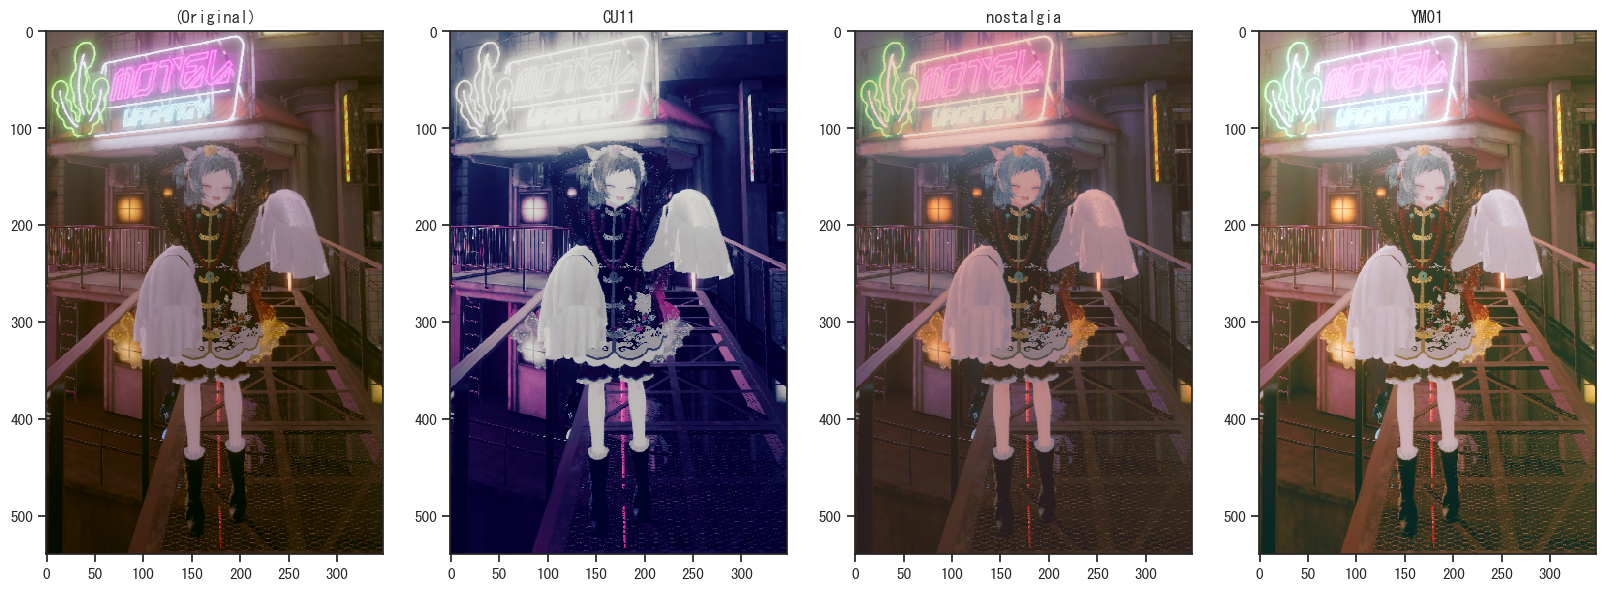

In [83]:
TO = Read(rf'{BASEDIR}/kobako.png')
g = GridPlot((1, 4),(20,10))
g.AddImg(TO, 1,"(Original)")

i=2
for PRESETNAME in ["CU11","nostalgia","YM01"]:
    M = np.load(f'{BASEDIR}/filters/{PRESETNAME}.npy')
    TO2 = M[TO[:, :, 0], TO[:, :, 1], TO[:, :, 2]]
    g.AddImg(TO2, i,PRESETNAME)
    i+=1
g.Show()

ValueError: x and y can be no greater than 2D, but have shapes (256,) and (256, 256, 256)

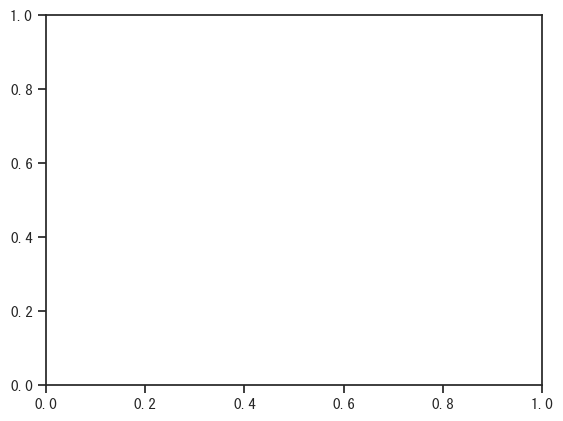

In [285]:
shape = M.shape
r, g, b = np.indices(shape[:-1])
coords = np.stack([r, g, b], axis=-1)
DIFF = M - coords

plt.plot(
DIFF[:,:,:,0]
)

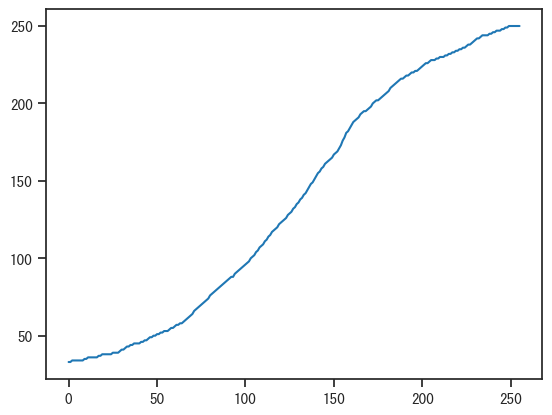

In [268]:
plt.plot(np.arange(0,256,1),M[:,90,50,0])

(array([  9112.,  48808., 162056., 246601., 379016., 399163., 289498.,
        259062., 259894., 276893., 256706., 234979., 298987., 264978.,
        263988., 253635., 269838., 301587., 318226., 292112., 299900.,
        314366., 314471., 330007., 361724., 510244., 399595., 395396.,
        408612., 439991., 429837., 404125., 393604., 418305., 463881.,
        444540., 526302., 675434., 575230., 606307., 600238., 559507.,
        509727., 416420., 373149., 296213., 172659.,  44780.,   6771.,
           742.]),
 array([  9.  ,  13.08,  17.16,  21.24,  25.32,  29.4 ,  33.48,  37.56,
         41.64,  45.72,  49.8 ,  53.88,  57.96,  62.04,  66.12,  70.2 ,
         74.28,  78.36,  82.44,  86.52,  90.6 ,  94.68,  98.76, 102.84,
        106.92, 111.  , 115.08, 119.16, 123.24, 127.32, 131.4 , 135.48,
        139.56, 143.64, 147.72, 151.8 , 155.88, 159.96, 164.04, 168.12,
        172.2 , 176.28, 180.36, 184.44, 188.52, 192.6 , 196.68, 200.76,
        204.84, 208.92, 213.  ]),
 <BarContainer obj

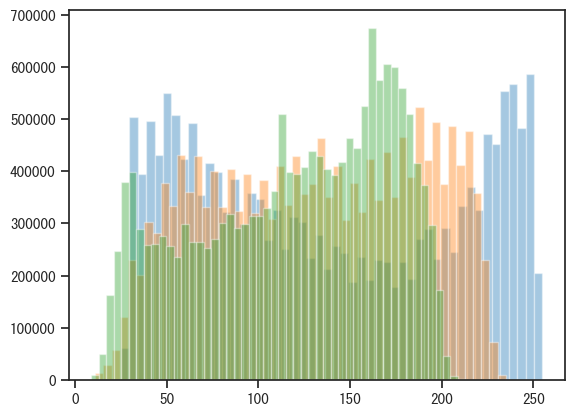

In [245]:
# for PRESETNAME in ["CU11","nostalgia","YM01"]:
PRESETNAME="nostalgia"
M = np.load(f'filters/{PRESETNAME}.npy')
M[:,:,:,0]
plt.hist(M[:,:,:,0].flatten(),alpha=0.4,bins=50)
plt.hist(M[:,:,:,1].flatten(),alpha=0.4,bins=50)
plt.hist(M[:,:,:,2].flatten(),alpha=0.4,bins=50)


### 調節

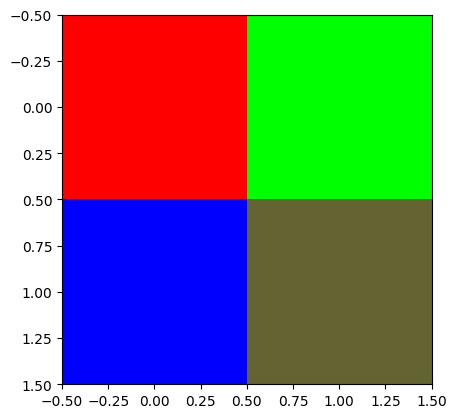

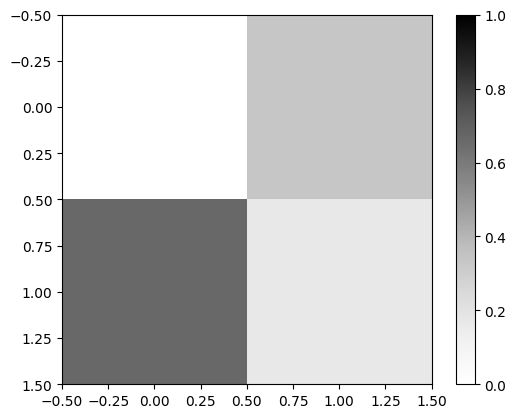

In [112]:
# test colorsys
imgdat = np.array(
    [[[255, 0, 0], [0, 255, 0]],
     [[0, 0, 255], [100, 100, 50]]],dtype="uint8"
)
plt.imshow(Image.fromarray(imgdat))
plt.show()

a=np.array([[ colorsys.rgb_to_hsv(r / 255, g / 255, b / 255)for r, g, b in i]for i in imgdat])

fig, ax = plt.subplots()
im = ax.imshow(a[:,:,0], cmap='Greys',vmin=0,vmax=1)
plt.colorbar(im, ax=ax)# 凡例バーを表示
plt.show()


In [72]:
def my_func(a):
    """Average first and last element of a 1-D array"""
    return a.sum()
b = np.array([[1,2,3], [4,5,6], [7,8,9]])
np.apply_along_axis(my_func, 0, b)


array([12, 15, 18])

In [29]:
import colorsys
in_[0,1]


a=[colorsys.rgb_to_hsv(r/255, g/255, b/255) for r,g,b in in_]

ValueError: too many values to unpack (expected 3)

色相Hは、RGBの最大値と最小値が同じ場合は0とする。そうでない場合は、

最大値がRのとき: (G - B) / (最大値 - 最小値) * 60
最大値がGのとき: (B - R) / (最大値 - 最小値) * 60 + 120
最大値がBのとき: (R - G) / (最大値 - 最小値) * 60 + 240
彩度Sは、RGBの最大値と最小値が同じ場合は0とする。そうでない場合は、

明度Vが0.5以下のとき: (最大値 - 最小値) / (最大値 + 最小値)
明度Vが0.5より大きいとき: (最大値 - 最小値) / (2 - 最大値 - 最小値)
明度Vは、RGBの最大値をそのまま用いる。

輝度Lは、RGBの平均をそのまま用いる。